In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as w
w.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost, lightgbm
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from scipy.stats import chi2_contingency
from statsmodels.stats import weightstats as stests
plt.rcParams['figure.figsize'] = [12,6]

In [161]:
df = pd.read_excel('Final Pakistan Dataset After Cleaning New.xlsx')
df.head(2)

,Unnamed: 0,item_id,status,price,qty_ordered,grand_total,increment_id,category_name,discount_amount,payment_method,Working Date,BI Status,Year,Month,FY,Customer ID
0,0,211131,Completed,1950.0,1,1950.0,100147443,Women's Fashion,0.0,cod,7/1/2016,#REF!,2016,7,FY17,1
1,1,211133,Canceled,240.0,1,240.0,100147444,Beauty & Grooming,0.0,cod,7/1/2016,Gross,2016,7,FY17,2


In [162]:
df=df[df['BI Status']!= "#REF!"]
df.drop(['Unnamed: 0', 'item_id', 'Customer ID', 'increment_id', 'Working Date'], axis = 1, inplace = True)

In [ ]:
#dropped customer id,item_id and increment id becuase they are i'd's.

In [163]:
df.describe()

,price,qty_ordered,grand_total,discount_amount,Year,Month
count,584219.000000,584219.000000,5.842190e+05,584219.000000,584219.000000,584219.000000
mean,6344.975734,1.284066,8.344576e+03,499.339073,2017.043771,7.168760
std,14826.168818,2.379960,2.180250e+04,1498.091452,0.707276,3.486321
min,0.000000,1.000000,0.000000e+00,-599.500000,2016.000000,1.000000
25%,360.000000,1.000000,9.460000e+02,0.000000,2017.000000,4.000000
50%,899.400000,1.000000,1.962000e+03,0.000000,2017.000000,7.000000
75%,4090.000000,1.000000,6.999000e+03,160.500000,2018.000000,11.000000
max,330499.000000,502.000000,1.315875e+06,50355.250000,2018.000000,12.000000


We can see the description table on the above discount column having negative values and that cannot be True, so we are checking rows which are having negative discount_amount values

In [164]:
df[df['discount_amount'] < 0]

,status,price,qty_ordered,grand_total,category_name,discount_amount,payment_method,BI Status,Year,Month,FY
152463,Canceled,5995.0,1,5395.5,Women's Fashion,-599.5,Payaxis,Gross,2017,2,FY17
152467,Canceled,4.0,2,156.0,\N,-2.0,Payaxis,Valid,2017,2,FY17
152468,Canceled,1000.0,5,4998.0,Superstore,-2.0,Payaxis,Gross,2017,2,FY17


We can see there are 3 rows in the discount_amount column and we cannot say why they are negative and 3 rows are very less percentage amoung the data so we are dropping those 3 records from the data set.

In [165]:
df = df[df['discount_amount'] >= 0]

In [166]:
round(df.var())

price              219816293.0
qty_ordered                6.0
grand_total        475351265.0
discount_amount      2244287.0
Year                       1.0
Month                     12.0
dtype: float64

In [167]:
df.corr()[abs(df.corr()) > 0.6]

,price,qty_ordered,grand_total,discount_amount,Year,Month
price,1.00000,NaN,0.77468,NaN,NaN,NaN
qty_ordered,NaN,1.0,NaN,NaN,NaN,NaN
grand_total,0.77468,NaN,1.00000,NaN,NaN,NaN
discount_amount,NaN,NaN,NaN,1.0,NaN,NaN
Year,NaN,NaN,NaN,NaN,1.000000,-0.634603
Month,NaN,NaN,NaN,NaN,-0.634603,1.000000


In [168]:
df_num = df.select_dtypes(np.number)
VIF = pd.DataFrame()
VIF['Features'] = df_num.columns
VIF["VIF"] = [variance_inflation_factor(df_num.values, i) for i in range(len(df_num.columns))]
VIF.sort_values(by = 'VIF', ascending=False, ignore_index = True)

,Features,VIF
0,Year,5.961331
1,Month,5.255006
2,price,3.477102
3,grand_total,2.920897
4,discount_amount,1.425507
5,qty_ordered,1.303936


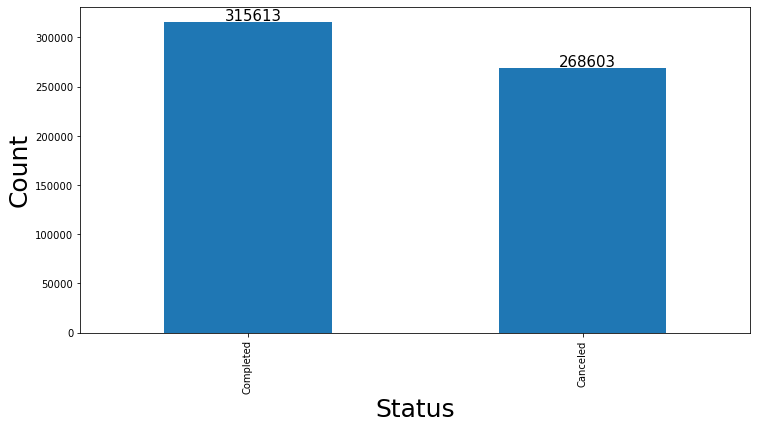

In [169]:
df['status'].replace(to_replace = ['Pending'], value = ['Completed'], inplace = True)
df['status'].value_counts().plot(kind = 'bar')
plt.ylabel('Count', fontsize = 25)
plt.xlabel('Status', fontsize = 25)
plt.text(x = -0.07, y = df['status'].value_counts()[0] + 1400, s = df['status'].value_counts()[0], fontsize = 15)
plt.text(x = 0.93, y = df['status'].value_counts()[1] + 2000, s = df['status'].value_counts()[1], fontsize = 15)
plt.show()

In [ ]:
# The target feature is balanced

In [171]:
for col in df.drop('status', axis = 1).columns:
    if df[col].dtypes=='O':
        table = pd.crosstab(df[col],df['status'])
        observed_value = table.values
        test_stat, p, dof, expected_value = chi2_contingency(observed = observed_value, correction = False)
        print("P-Value of {} for 5% significance level is : {}".format(col,"{:.10f}".format(p)))
    else:
        completed= df[(df['status'] == 'Completed')][col]
        cancelled = df[(df['status'] == 'Canceled')][col]
        z_score, p = stests.ztest(x1 = completed, x2 = cancelled, value = 0)
        print("P-Value of {} for 5% significance level is : {}".format(col,"{:.10f}".format(p)))

P-Value of price for 5% significance level is : 0.0000000000
P-Value of qty_ordered for 5% significance level is : 0.0000000000
P-Value of grand_total for 5% significance level is : 0.0000000000
P-Value of category_name for 5% significance level is : 0.0000000000
P-Value of discount_amount for 5% significance level is : 0.0000000000
P-Value of payment_method for 5% significance level is : 0.0000000000
P-Value of BI Status for 5% significance level is : 0.0000000000
P-Value of Year for 5% significance level is : 0.0000000000
P-Value of Month for 5% significance level is : 0.0000000000
P-Value of FY for 5% significance level is : 0.0000000000


In [ ]:
# For Numerical variables P value is less than alpha(5%) so Reject(Accept H1) to Null i.e. Means are not equal
# For Categorical variables P value is less than alpha(5%) so Reject((Accept H1)) to Null i.e. Input and Target variables are dependent

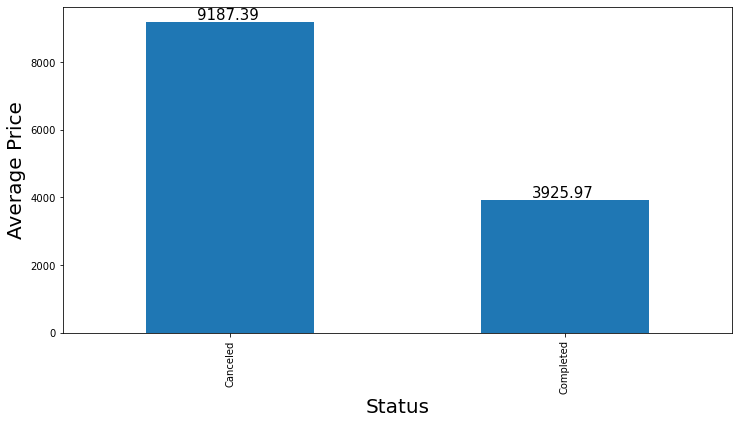

In [172]:
df.groupby('status')['price'].mean().plot(kind = 'bar')
plt.text(x = -0.1, y = df[df['status'] == 'Canceled']['price'].mean() + 80, 
         s = round(df[df['status'] == 'Canceled']['price'].mean(), 2), fontsize = 15)
plt.text(x = 0.9, y = df[df['status'] == 'Completed']['price'].mean() + 80, 
         s = round(df[df['status'] == 'Completed']['price'].mean(), 2), fontsize = 15)
plt.xlabel('Status', fontsize = 20)
plt.ylabel('Average Price', fontsize = 20)
plt.show()

In [173]:
df_input = df[['price', 'qty_ordered', 'category_name', 'discount_amount', 'payment_method']]
df_target = df['status']
df_target.replace(to_replace = ['Completed', 'Canceled'], value = [1, 0], inplace = True)

- Input/Independent Features : `price`, `qty_ordered`, `category_name`, `discount_amount`, `payment_method`
- Target/Dependent Feature : `status`

In [176]:
def order_status_prediction_preprocessing(df_input, df_target):

    # train_test_split
    X_train, X_test, y_train, y_test = train_test_split(df_input, df_target, test_size = 0.25, random_state = 10)
    
    # Applying Preprocessing techniques on train and test data sets\
    
    X_num_train = X_train.select_dtypes(np.number)
    X_cat_train = X_train.select_dtypes('O')
    X_num_test = X_test.select_dtypes(np.number)
    X_cat_test = X_test.select_dtypes('O')
    
    # Dummy Encoding
    X_cat_train = pd.get_dummies(X_cat_train, drop_first = True)
    X_cat_test = pd.get_dummies(X_cat_test, drop_first = True)
    
    # Scaling to continuous data
    sc = StandardScaler()
    X_num_train = pd.DataFrame(sc.fit_transform(X_num_train), columns = X_num_train.columns)
    X_num_test = pd.DataFrame(sc.transform(X_num_test), columns = X_num_test.columns)
    
    X_num_train.reset_index(drop = True, inplace = True)
    X_num_test.reset_index(drop = True, inplace = True)
    X_cat_train.reset_index(drop = True, inplace = True)
    X_cat_test.reset_index(drop = True, inplace = True)
    
    # Merging the continuous and categorical data
    X_train_final = pd.concat([X_num_train, X_cat_train], axis = 1)
    X_test_final = pd.concat([X_num_test, X_cat_test], axis = 1)

    return X_train_final, X_test_final, y_train, y_test

In [178]:
# Calling the preprocessing function
X_train, X_test, y_train, y_test = order_status_prediction_preprocessing(df_input, df_target)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(438162, 35) (146054, 35) (438162,) (146054,)


In [189]:
# Defining a model training and scoring function

scorecard=pd.DataFrame(columns=['Model','tn','fp','fn','tp','Precision','Recall',
                    'F1_score','ROC AUC Score','Train_Accuracy','Test_Accuracy','Kappa_score'])
def order_status_prediction_model_train_and_score(estimator,X_train,y_train,x_test,y_test):
#     print("________"+estimator.__class__.__name__+"__________")
#     print('******'*10)
    # traing data 
    model=estimator.fit(X_train,y_train)
    y_train_pred=model.predict(X_train)
#     print('\nPerformance of the model on Training Data')
#     print('******'*10)
#     print('\nConfusion matrix:\n')
#     print(confusion_matrix(y_train,y_train_pred))
#     print('\nClassification report:\n')
#     print(classification_report(y_train,y_train_pred))
    #testing data
    y_test_pred=model.predict(X_test)
#     print('\nPerformance of the model on testing Data')
#     print('******'*10)
#     print('\nConfusion matrix:\n')
#     print(confusion_matrix(y_test,y_test_pred))
#     print('\nClassification report:\n')
#     print(classification_report(y_test,y_test_pred))
    Train_accuracy = accuracy_score(y_train, y_train_pred)
    Test_accuracy = accuracy_score(y_test, y_test_pred)
#     print('\nTrain set Accuracy:',Train_accuracy)
#     print('Test set Accuracy:',Test_accuracy)
#     print('\n')
    tn,fp,fn,tp=confusion_matrix(y_test,y_test_pred).flatten()
    y_test_prob = estimator.predict_proba(X_test)[:, 1]
    area = roc_auc_score(y_test,y_test_prob)
#     fpr,tpr,threshold=roc_curve(y_test,y_test_prob)
#     plt.rcParams['figure.figsize'] = [10,6]
#     plt.plot(fpr, tpr, label = estimator.__class__.__name__)
#     plt.plot([0,1],[0,1],'r--')
#     plt.xlabel('FPR (False Positive Rate || 1 - Specificity)', fontsize = 15)
#     plt.ylabel('TPR (True Positive Rate || Sensitivity)', fontsize = 15)
#     plt.title('ROC AUC Analysis for Order Status Prediction', fontsize = 15)
#     plt.xlim([0,1])
#     plt.ylim([0,1])
#     plt.text(x = 0.02, y = 0.85, s = 'Area under curve : ' + str(round(area, 3)), fontsize = 12)
#     plt.legend(fontsize = 12)
#     plt.grid(True)
#     plt.show()
    
    global scorecard
    class_name = estimator.__class__.__name__
    if class_name == 'BaggingClassifier':
        class_name = class_name + ' (' + estimator.base_estimator_.__class__.__name__ + ')'
        
    scorecard=scorecard.append({'Model':class_name
                               ,'tn':tn
                               ,'fp':fp
                               ,'fn':fn
                               ,'tp':tp
                               ,'Precision':precision_score(y_test,y_test_pred)
                               ,'Recall':recall_score(y_test,y_test_pred)
                               ,'F1_score':f1_score(y_test,y_test_pred)
                               ,'ROC AUC Score':area
                               ,'Train_Accuracy':Train_accuracy
                               ,'Test_Accuracy':Test_accuracy
                               ,'Kappa_score':cohen_kappa_score(y_test,y_test_pred)},ignore_index=True)
    
    fi = pd.DataFrame()
    if((estimator.__class__.__name__ != 'LogisticRegression') & (estimator.__class__.__name__ != 'GaussianNB')
      & (estimator.__class__.__name__ != 'BaggingClassifier') & (estimator.__class__.__name__ != 'StackingClassifier')
      & (estimator.__class__.__name__ != 'VotingClassifier')):
        fi['Feature'] = list(X_train.columns)
        fi['Importance_Score'] = estimator.feature_importances_
        fi = fi.sort_values(by = 'Importance_Score', ascending = False)
        fi_name = estimator.__class__.__name__ + '_Feature_Importance.csv'
        fi.to_csv(fi_name)                        
    

**Calling the model train and score function for different SLC algorithms**

In [191]:
order_status_prediction_model_train_and_score(LogisticRegression(), X_train, y_train, X_test, y_test)
order_status_prediction_model_train_and_score(GaussianNB(), X_train, y_train, X_test, y_test)
order_status_prediction_model_train_and_score(DecisionTreeClassifier(), X_train, y_train, X_test, y_test)
order_status_prediction_model_train_and_score(ExtraTreeClassifier(), X_train, y_train, X_test, y_test)
order_status_prediction_model_train_and_score(RandomForestClassifier(), X_train, y_train, X_test, y_test)
order_status_prediction_model_train_and_score(AdaBoostClassifier(), X_train, y_train, X_test, y_test)
order_status_prediction_model_train_and_score(GradientBoostingClassifier(), X_train, y_train, X_test, y_test)
order_status_prediction_model_train_and_score(XGBClassifier(), X_train, y_train, X_test, y_test)
order_status_prediction_model_train_and_score(LGBMClassifier(), X_train, y_train, X_test, y_test)
order_status_prediction_model_train_and_score(
    BaggingClassifier(base_estimator = LogisticRegression()), X_train, y_train, X_test, y_test)
order_status_prediction_model_train_and_score(
    BaggingClassifier(base_estimator = GaussianNB()), X_train, y_train, X_test, y_test)
estimators = [('LR', LogisticRegression()), ('ET', ExtraTreeClassifier()), ('RF', RandomForestClassifier())]
order_status_prediction_model_train_and_score(
    StackingClassifier(estimators = estimators, final_estimator = XGBClassifier()), X_train, y_train, X_test, y_test)
estimators = [('LR', LogisticRegression()), ('ET', ExtraTreeClassifier()), 
              ('RF', RandomForestClassifier()), ('XGB', XGBClassifier())]
order_status_prediction_model_train_and_score(
    VotingClassifier(estimators = estimators, voting = 'soft'), X_train, y_train, X_test, y_test)

[13:32:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:40:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:41:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [195]:
scorecard

,Model,tn,fp,fn,tp,Precision,Recall,F1_score,ROC AUC Score,Train_Accuracy,Test_Accuracy,Kappa_score
0,LogisticRegression,43143,23945,20947,58019,0.707860,0.734734,0.721046,0.746758,0.692595,0.692634,0.379089
1,GaussianNB,31413,35675,16239,62727,0.637457,0.794355,0.707309,0.684295,0.642796,0.644556,0.268439
2,DecisionTreeClassifier,44166,22922,18489,60477,0.725153,0.765861,0.744951,0.746137,0.807532,0.716468,0.426309
3,ExtraTreeClassifier,44246,22842,18641,60325,0.725348,0.763936,0.744142,0.746111,0.807539,0.715975,0.425462
4,RandomForestClassifier,42888,24200,16728,62238,0.720031,0.788162,0.752557,0.777970,0.807503,0.719775,0.431052
5,AdaBoostClassifier,40847,26241,16890,62076,0.702877,0.786110,0.742167,0.767377,0.704760,0.704691,0.399152
6,GradientBoostingClassifier,43380,23708,18698,60268,0.717681,0.763215,0.739748,0.773958,0.709938,0.709655,0.412143
7,XGBClassifier,43519,23569,17255,61711,0.723628,0.781488,0.751446,0.788489,0.727881,0.720487,0.433240
8,LGBMClassifier,43547,23541,17963,61003,0.721553,0.772522,0.746168,0.782800,0.718803,0.715831,0.424278
9,BaggingClassifier (LogisticRegression),43166,23922,20960,58006,0.708012,0.734569,0.721046,0.746825,0.692746,0.692703,0.379252


In [198]:
scorecard.to_csv('scorecard.csv')                  

In [ ]:
# Applying GridSearchCV technique

In [104]:
hyper_params = [{'n_estimators' : [50,100],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [4,6,8],
    'min_samples_split' : [5,10,15]}]
kf=KFold(n_splits=3,shuffle=True,random_state=0)
RF = RandomForestClassifier(random_state = 10)
rf_grid = GridSearchCV(estimator = RF, param_grid = hyper_params, cv = kf, scoring='accuracy')
rf_grid = rf_grid.fit(X_train, y_train)
print('Optimal number of trees for random forest Classifier: ', rf_grid.best_params_, '\n')

Optimal number of trees for random forest Classifier:  {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 100} 



In [196]:
rf = RandomForestClassifier(max_depth = 8, min_samples_split = 5)
rf_model = rf.fit(X_train, y_train)
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)
accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test)

(0.7056636586468019, 0.7053007791638709)

In [ ]:
hyper_params = [{'learning_rate': [0.6, 0.8], 'max_depth': [5,6], 'gamma': [1, 2]}]
kf=KFold(n_splits=3,shuffle=True,random_state=0)
xgb = XGBClassifier(random_state = 10)
xgb_grid = GridSearchCV(estimator = xgb, param_grid = hyper_params, cv = kf, scoring='accuracy')
xgb_grid = xgb_grid.fit(X_train, y_train)

In [134]:
print('Optimal number of trees for random forest Classifier: ', xgb_grid.best_params_, '\n')

Optimal number of trees for random forest Classifier:  {'gamma': 1, 'learning_rate': 0.6, 'max_depth': 6} 



In [132]:
xgb = XGBClassifier(gamma = 1, learning_rate = 0.6, max_depth = 6)
xgb_model = xgb.fit(X_train, y_train)
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)
accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test)

[11:10:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(0.7346848882376837, 0.7255828283865667)